# Demonstration 

# 1. Import modules

In [27]:
import numpy as np
import os
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
import pandas as pd
import tensorflow.keras.utils as image_processing
from PIL import Image
import exifread
import requests

# 2. Paths

In [28]:
CURR_DIR_PATH = os.getcwd()

# Training paths
seg_train_path = CURR_DIR_PATH + "//data//seg_train//seg_train"

train_forest_path = seg_train_path + "//forest"
train_buildings_path = seg_train_path + "//buildings"
train_glacier_path = seg_train_path + "//glacier"
train_mountain_path = seg_train_path + "//mountain"
train_sea_path = seg_train_path + "//sea"
train_street_path = seg_train_path + "//street"

# Test paths
seg_test_path = CURR_DIR_PATH + "//data//seg_test//seg_test"

test_forest_path = seg_test_path + "//forest"
test_buildings_path = seg_test_path + "//buildings"
test_glacier_path = seg_test_path + "//glacier"
test_mountain_path = seg_test_path + "//mountain"
test_sea_path = seg_test_path + "//sea"
test_street_path = seg_test_path + "//street"

# Prediction path
seg_pred_path = CURR_DIR_PATH + "//data//seg_pred//seg_pred"

# Our path
seg_our_path = CURR_DIR_PATH + "//data//seg_our//seg_our"

# 3. Load and transform images

In [29]:
def load_data(paths):
    images = []
    labels = []
    label = -1
    for path in paths:
        label = label+1
        for file in (os.listdir(path)):
            image_path = os.path.join(path, file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(150, 150)) 
            image = image/ 255.0
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    output = (images,labels)
    return output

In [30]:
train_paths = [train_buildings_path, train_forest_path, train_glacier_path, train_mountain_path, train_sea_path, train_street_path]
test_paths = [test_buildings_path, test_forest_path, test_glacier_path, test_mountain_path, test_sea_path, test_street_path]
train_images, train_labels= load_data(train_paths)
print (f"Number of training images: {train_labels.shape[0]}") 
test_images, test_labels = load_data(test_paths)
print (f"Number of testing images: {test_labels.shape[0]}") 

Number of training images: 14034
Number of testing images: 3000


In [31]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# 4. Create and train model

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [33]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=40, validation_split = 0.2)

Epoch 1/40
88/88 [==============================] - 118s 1s/step - loss: 1.3924 - accuracy: 0.5103 - val_loss: 0.9086 - val_accuracy: 0.6641
Epoch 2/40
88/88 [==============================] - 114s 1s/step - loss: 0.7831 - accuracy: 0.7120 - val_loss: 0.7641 - val_accuracy: 0.7143
Epoch 3/40
88/88 [==============================] - 113s 1s/step - loss: 0.6260 - accuracy: 0.7767 - val_loss: 0.7464 - val_accuracy: 0.7178
Epoch 4/40
88/88 [==============================] - 115s 1s/step - loss: 0.5139 - accuracy: 0.8217 - val_loss: 0.7036 - val_accuracy: 0.7463
Epoch 5/40
88/88 [==============================] - 113s 1s/step - loss: 0.3959 - accuracy: 0.8659 - val_loss: 0.7018 - val_accuracy: 0.7471
Epoch 6/40
88/88 [==============================] - 118s 1s/step - loss: 0.2978 - accuracy: 0.8993 - val_loss: 0.6910 - val_accuracy: 0.7610
Epoch 7/40
88/88 [==============================] - 115s 1s/step - loss: 0.2220 - accuracy: 0.9309 - val_loss: 0.7610 - val_accuracy: 0.7592
Epoch 8/40
88

In [35]:
category_label=['buildings','forest', 'glacier','mountain','sea','street']
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

94/94 [==============================] - 8s 83ms/step


# Random Images from dataset

In [36]:
def display_random_image(category_label, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(f'Image #{index} : {category_label[labels[index]]} ')
    plt.show()

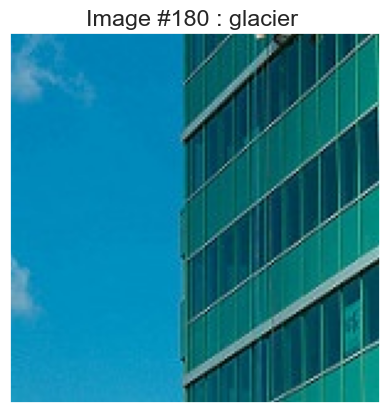

In [37]:
display_random_image(category_label, test_images, pred_labels)

# Plot images with predictions from dataset

In [38]:
def processing(path):
    img = cv2.imread(path)
    test1_proc = image_processing.load_img(path , target_size=(150,150))
    test1_proc_1 = image_processing.img_to_array(test1_proc)
    t1 = np.expand_dims(test1_proc ,axis=0)
    t1 = t1/255
    pred_classes = model.predict(t1)
    pred = np.argmax(pred_classes ,axis=1)

    plt.subplot(121)
    pic = Image.open(path) 
    plt.xlabel("Original Image")
    plt.imshow(pic)
    
    
    plt.subplot(122)

    s1 = pd.Series(pred_classes.ravel() , index = category_label)
    s1.plot(kind = 'bar' ,figsize = (10,5))
    plt.xlabel("prediction")
    
    plt.show()

# Processed images from dataset

1/1 [==============================] - 0s 29ms/step


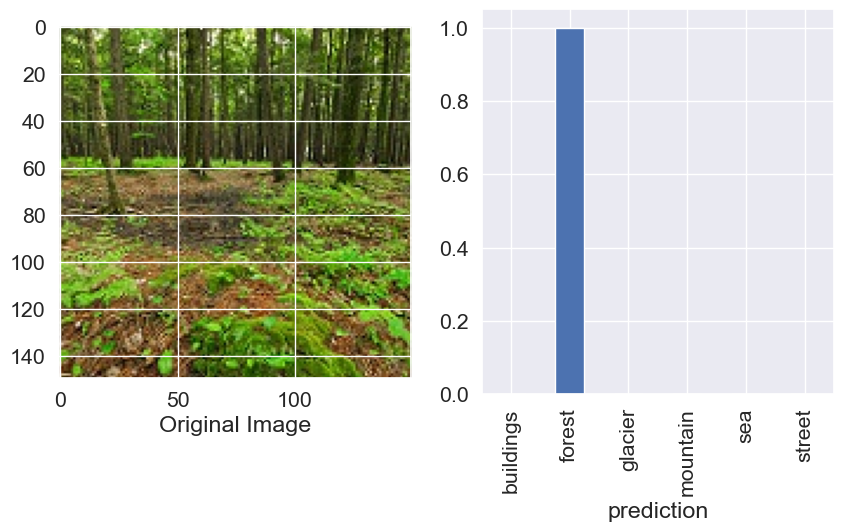

1/1 [==============================] - 0s 27ms/step


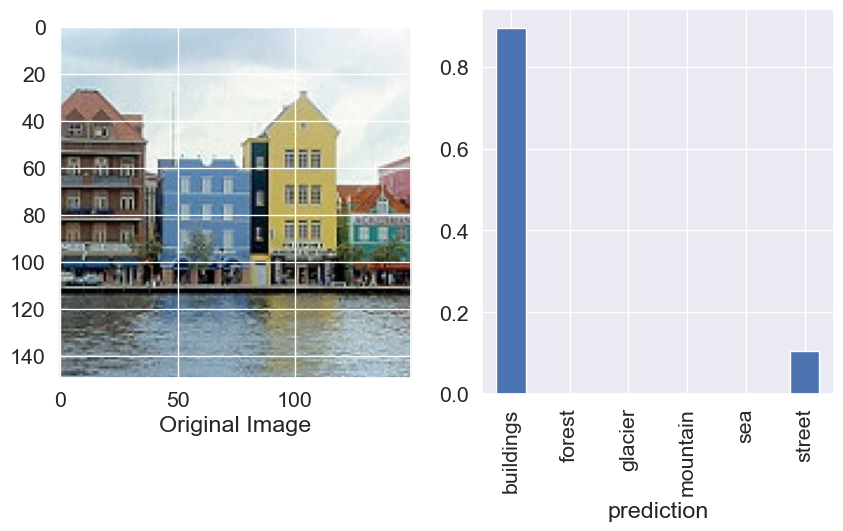

1/1 [==============================] - 0s 27ms/step


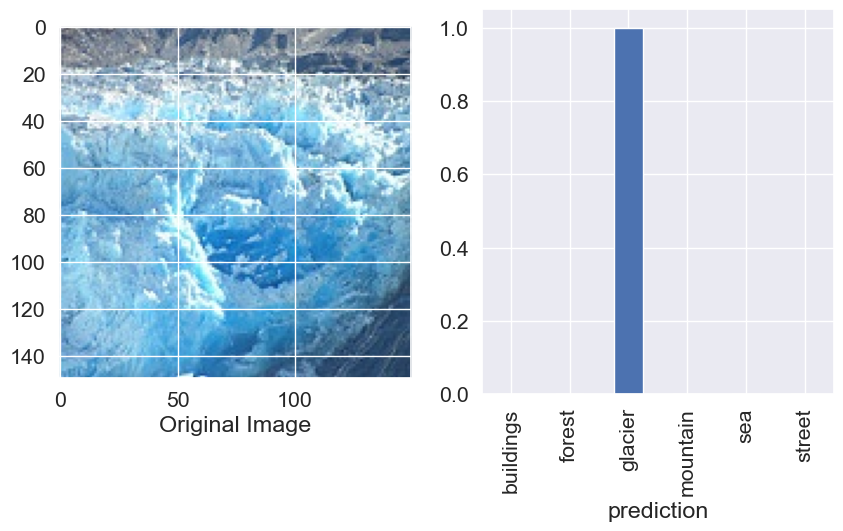

1/1 [==============================] - 0s 28ms/step


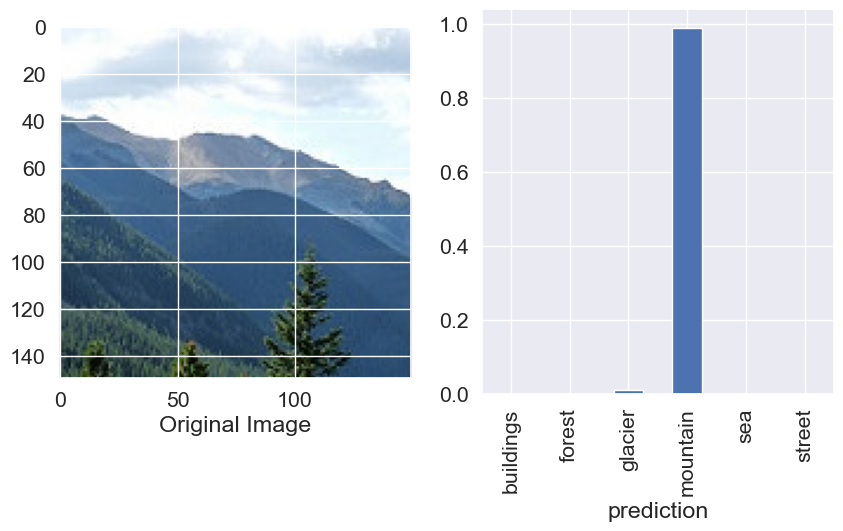

1/1 [==============================] - 0s 32ms/step


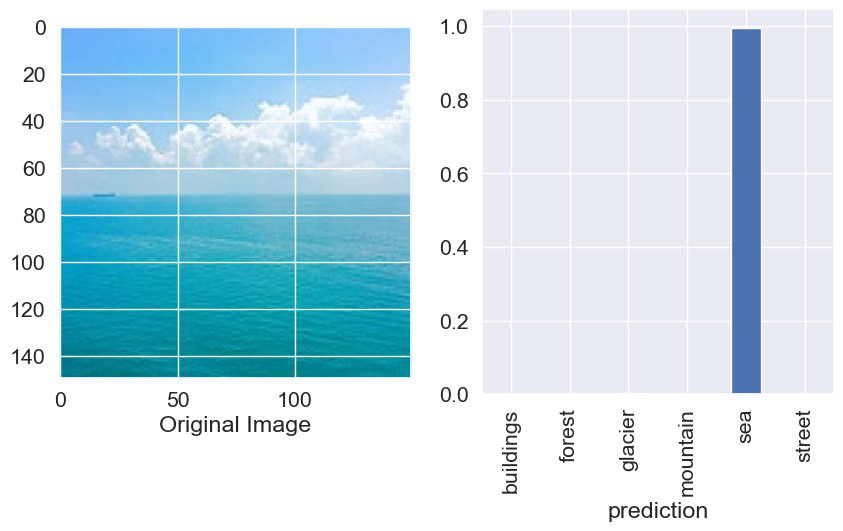

1/1 [==============================] - 0s 39ms/step


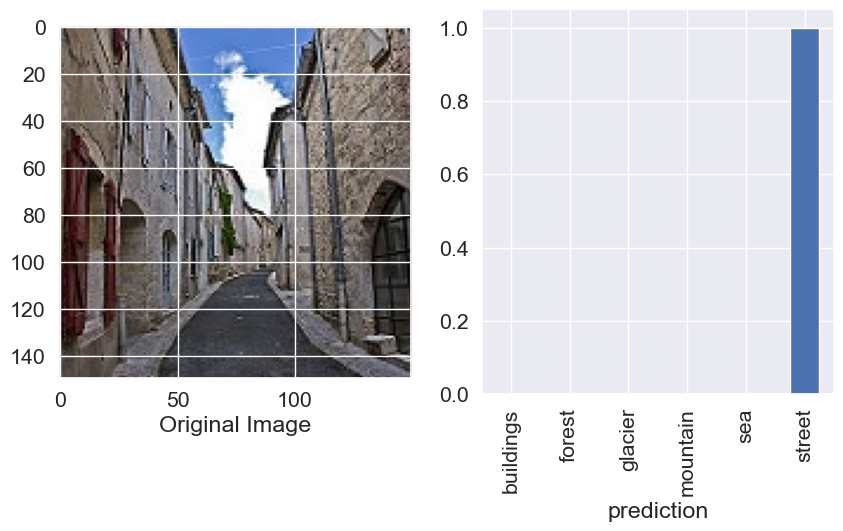

In [39]:
processing(test_forest_path + "/20173.jpg")
processing(test_buildings_path + "/20635.jpg")
processing(test_glacier_path + "/20087.jpg")
processing(test_mountain_path + "/21096.jpg")
processing(test_sea_path + "/22664.jpg")
processing(test_street_path + "/20234.jpg")

# Proccessing our own images

1/1 [==============================] - 0s 30ms/step


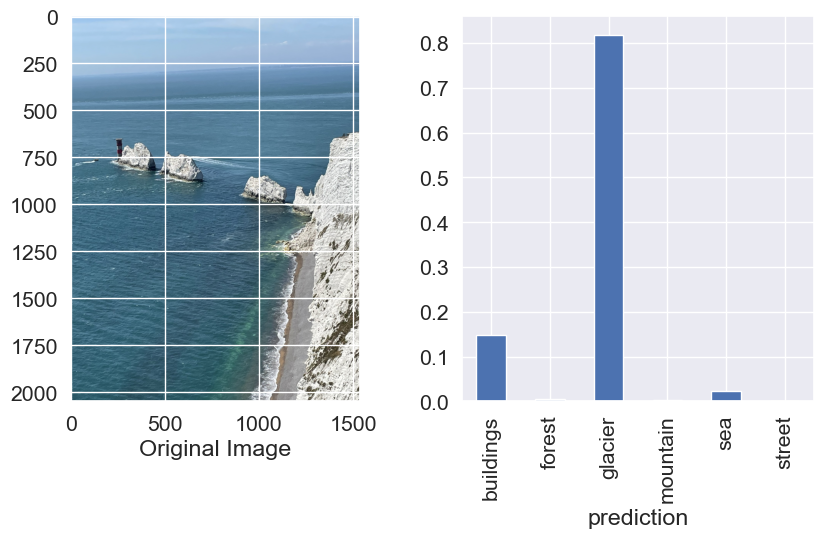

1/1 [==============================] - 0s 28ms/step


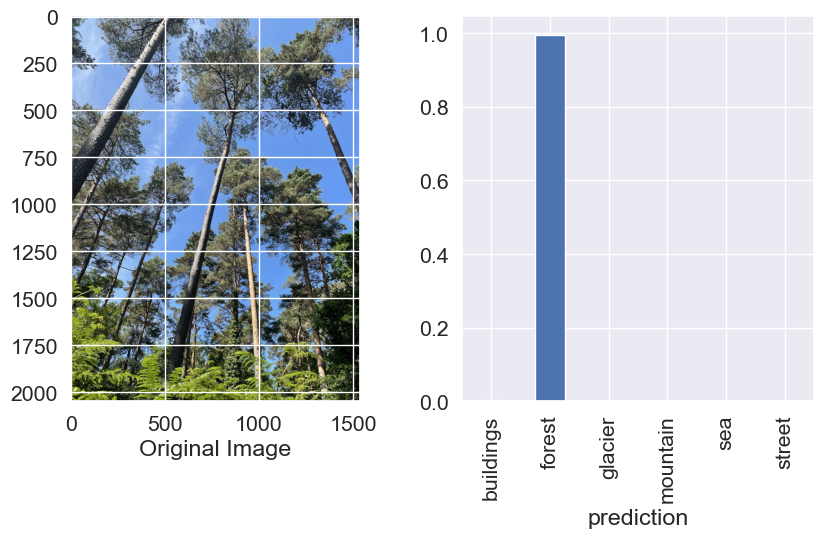

1/1 [==============================] - 0s 26ms/step


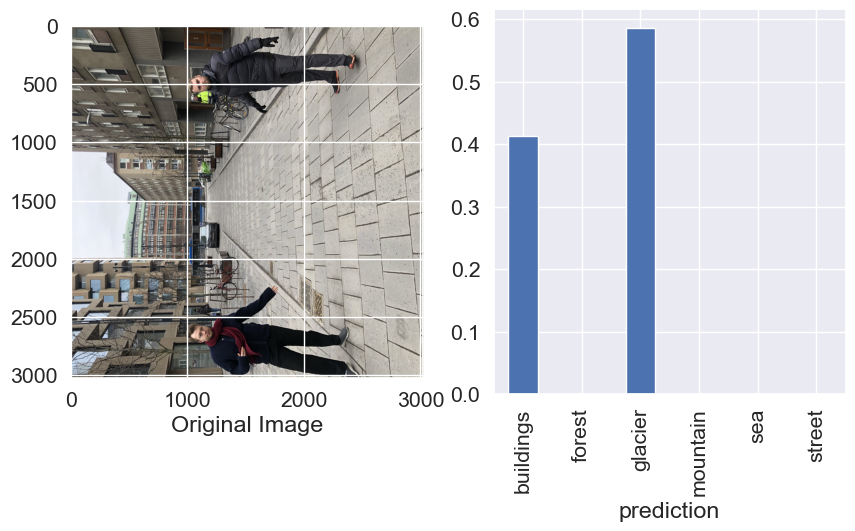

1/1 [==============================] - 0s 24ms/step


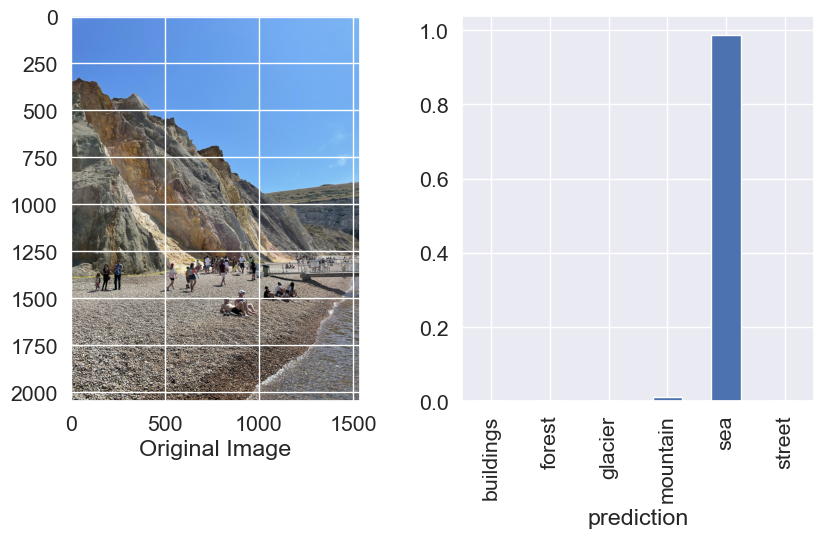

1/1 [==============================] - 0s 25ms/step


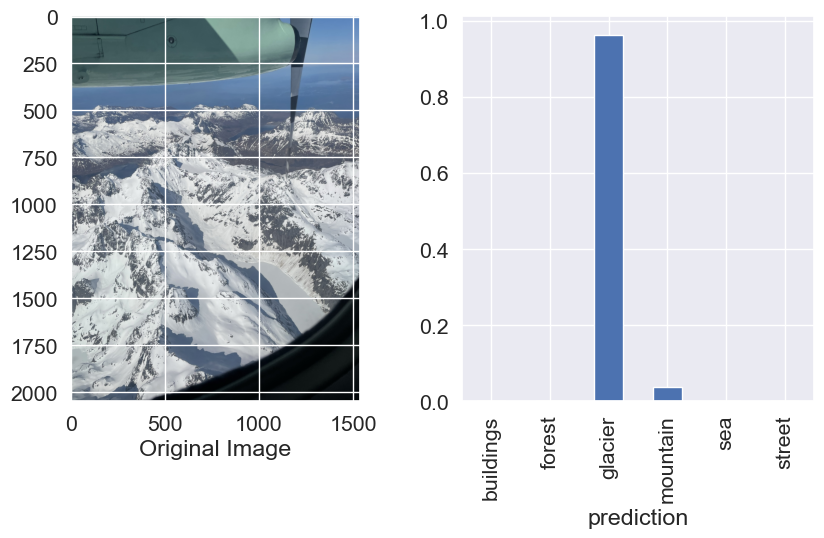

1/1 [==============================] - 0s 28ms/step


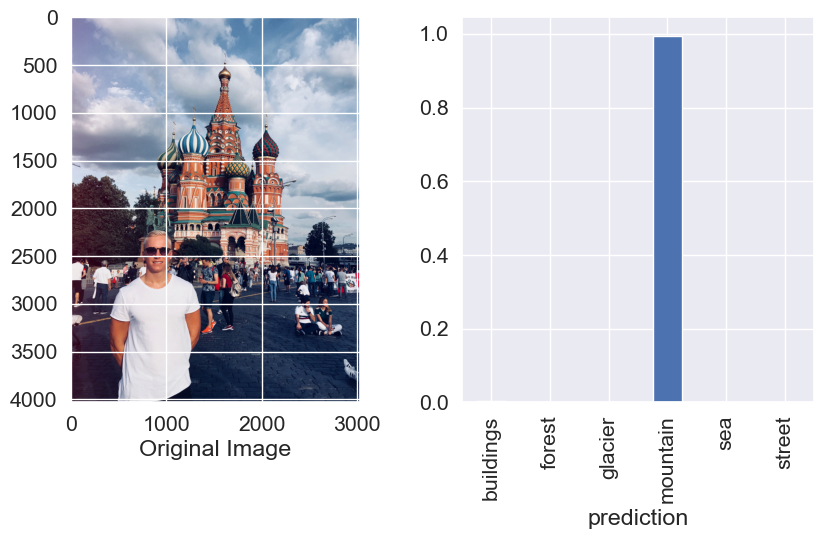

In [40]:
for file in os.listdir(seg_our_path)[:6]:
    image_path = (os.path.join(seg_our_path, file))
    processing(image_path)

# Geo location

In [1]:
def extract_gps_info(image_path):
    with open(image_path, 'rb') as image_file:
        tags = exifread.process_file(image_file)
        lat_deg = tags.get('GPS GPSLatitude', None)
        lat_ref = tags.get('GPS GPSLatitudeRef', None)
        long_deg = tags.get('GPS GPSLongitude', None)
        long_ref = tags.get('GPS GPSLongitudeRef', None)
        timestamp = tags.get('EXIF DateTimeOriginal', None)
        latitude = convert_to_degrees(lat_deg, lat_ref)
        longitude = convert_to_degrees(long_deg, long_ref)
        return (latitude, longitude, timestamp)

def convert_to_degrees(coordinate, ref):
    coordinate = list(coordinate.values)
    d = float(coordinate[0].num) / coordinate[0].den
    m = float(coordinate[1].num) / coordinate[1].den
    s = float(coordinate[2].num) / coordinate[2].den
    result = d + (m / 60.0) + (s / 3600.0)
    if str(ref) == 'S' or str(ref) == 'W':
        result *= -1
    return result

def get_location_name(latitude, longitude):
    url = f"https://nominatim.openstreetmap.org/reverse?format=json&lat={latitude}&lon={longitude}"
    response = requests.get(url)
    location_name = response.json().get('address').get('town') or response.json().get('address').get('city')
    country = response.json().get('address').get('country')
    return location_name, country

CURR_DIR_PATH = os.getcwd()
image_path = CURR_DIR_PATH + '//data//seg_our//seg_our//live.jpg' ######## Ändra test.jpg #######
location = extract_gps_info(image_path)
if location:
    print("\nThe geolocation information for the photo:")
    print("Timestamp:", location[2])
    print("Latitude: {:.6f}°".format(location[0]))
    print("Longitude: {:.6f}°".format(location[1]))
    location_name, country = get_location_name(location[0], location[1])
    print("Country:", country)
    print("Location name:", location_name)
    
else:
    print("\nNo geolocation information found in the photo.")

processing(image_path)

NameError: name 'os' is not defined